In [93]:
import cv2
import imutils
import numpy as np
import time
from matplotlib import pyplot as plt
from keras.models import load_model
import PIL
from PIL import Image, ImageDraw, ImageFont, ImageOps
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import copy
import math


In [74]:
def loadImage(path):
        return cv2.imread(path)

originalImagePath = "/Users/patrickbell/Documents/sodukuAI/puzzleDetector/Sample2.png"
originalImage = loadImage(originalImagePath)
    
    
# Updates upper and lower black colors for mask
def findGridColor(image):
    threshhold = 0.4
    for i in range(image.shape[0]):
        color = image[i][i]
        if color[0] < 200 and color[1] < 200 and color[2] < 200:
            blackLower = (
                color[0]-color[0]*threshhold, color[1]-color[1]*threshhold, color[2]-color[2]*threshhold)
            blackUpper = (
                color[0]+color[0]*threshhold, color[1]+color[1]*threshhold, color[2]+color[2]*threshhold)
            break
#     print(blackLower, blackUpper)
    return blackLower, blackUpper
    # TODO: Debug lower & upper values here
    
def cropToGrid(image):
    blackLower, blackUpper = findGridColor(image)
    mask = cv2.inRange(image, blackLower, blackUpper)
    # TODO: Debug show mask

    cnts = cv2.findContours(
        mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnt = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Assign coordinates of rectangle
    topLeftCornerX = box[1][0]
    topLeftCornerY = box[1][1]
    bottomRightCornerX = box[3][0]
    bottomRightCornerY = box[3][1]
    gridCorners = (topLeftCornerX, topLeftCornerY,
                        bottomRightCornerX, bottomRightCornerY)
    croppedImageWithGrid = image[topLeftCornerY:bottomRightCornerY, topLeftCornerX:bottomRightCornerX]
    return croppedImageWithGrid

def showImage(image, title):
        cv2.imshow(title, image)
        cv2.waitKey(0)
        cv2.destroyAllWindows();
        cv2.waitKey(1)


In [76]:
def pixelIsBlack(pixel):
    blackValue = 200
    if pixel[0] < blackValue and pixel[1] < blackValue and pixel[2] < blackValue:
        return True
    else:
        return False
        
        

# TODO: Should consider what happens if image doesn't have a white border.
# May want to crop to grid first to avoid accidentally getting on a line
def findLines(image):
    # Image goes
    # originalImage[height, width]
    # 
    # (0,0) --------> originalImage[0][100]
    # |
    # |
    # |
    # |
    # originalImage[100][0]
    
    
    # Height, width, channels
    shape = image.shape
    # Gets x coordinates of 1/6, 3/6, 5/6 of image to navigate downward
    xPoints = [int(shape[1]/6), int(shape[1]/6)*3, int(shape[1]/6)*5]
    yPoints = [int(shape[0]/6), int(shape[0]/6)*3, int(shape[0]/6)*5]
    
    horizontalLines = []
    i = 0
    while i < shape[0]:
        point1 = image[i, xPoints[0]]
        point2 = image[i, xPoints[1]]
        point3 = image[i, xPoints[2]]
#         print(point1, point2, point3, '\n')
        lineStart = None
        if pixelIsBlack(point1) and pixelIsBlack(point2) and pixelIsBlack(point3):
            lineStart = i
            while pixelIsBlack(point1) and pixelIsBlack(point2) and pixelIsBlack(point3) and i < shape[0]:
                i = i + 1
                point1 = image[i, xPoints[0]]
                point2 = image[i, xPoints[1]]
                point3 = image[i, xPoints[2]]
                
            if lineStart:
                horizontalLines.append((lineStart,i-1))
        i = i+1
        
    verticalLines = []
    i = 0
    while i < shape[1]:
        point1 = image[yPoints[0], i]
        point2 = image[yPoints[1], i]
        point3 = image[yPoints[2], i]
#         print(point1, point2, point3, '\n')
        lineStart = None
        if pixelIsBlack(point1) and pixelIsBlack(point2) and pixelIsBlack(point3):
            lineStart = i
            while pixelIsBlack(point1) and pixelIsBlack(point2) and pixelIsBlack(point3) and i < shape[1]:
                i = i + 1
                point1 = image[yPoints[0], i]
                point2 = image[yPoints[1], i]
                point3 = image[yPoints[2], i]
                
            if lineStart:
                verticalLines.append((lineStart,i-1))
        i = i+1
    
    
    return {"horizontalLines": horizontalLines, "verticalLines": verticalLines}
    
    

In [81]:
def getCells(image, horizontalLines, verticalLines):
    cells = []
    for i in range(9):
        row = []
        for i in range(9):
            row.append(None)
        cells.append(row)
    
    for i in range(len(horizontalLines) -1):
        horizontalCellBounds = (horizontalLines[i][1], horizontalLines[i+1][0])
        for j in range(len(verticalLines)-1):
            verticalCellBounds = (verticalLines[j][1], verticalLines[j+1][0])
            cell = image[horizontalCellBounds[0]:horizontalCellBounds[1], verticalCellBounds[0]:verticalCellBounds[1]]
            cells[i][j] = cell
    
    return cells
            
        

In [83]:
lines = findLines(originalImage)

In [84]:
cells = getCells(originalImage, lines['horizontalLines'], lines['verticalLines'])

In [68]:
showImage(originalImage, "Original")

In [58]:
showImage(cells[2][0], "Cell")

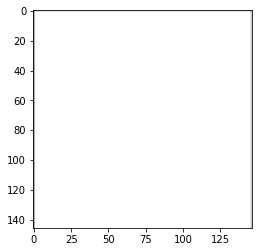

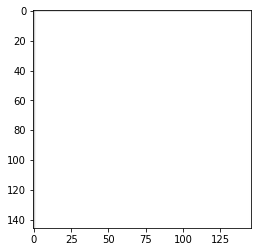

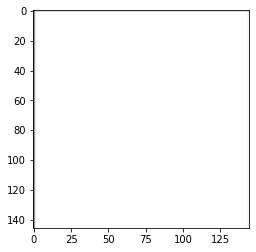

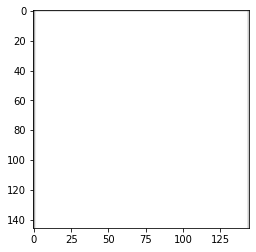

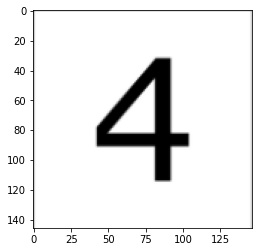

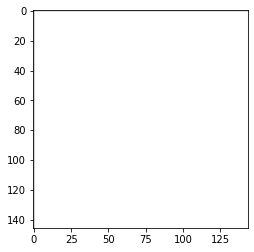

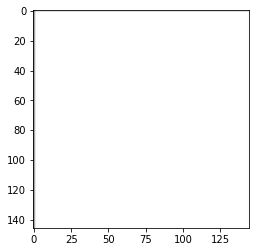

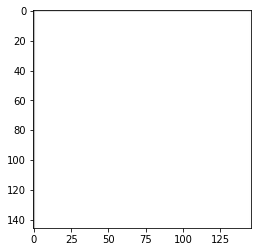

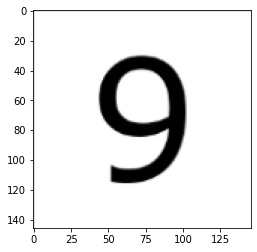

In [86]:
for i in range(9):
    plt.imshow(cells[8][i])
    plt.show()

In [94]:
class DigitClassifierNN:
    def __init__(self):
        self.model = None
        self.class_names = []

    def trainNewModel(self, pathToImages):
        data_dir = pathToImages
        batch_size = 32
        img_height = 100
        img_width = 100
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="training",
            seed=123,
            batch_size=batch_size,
            image_size=(img_height, img_width)
        )
        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size
        )
        self.class_names = train_ds.class_names

        # Caches for performance
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

        # Creating the NN
        model = Sequential([
            layers.experimental.preprocessing.Rescaling(
                1./255, input_shape=(img_height, img_width, 3)),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(self.class_names))
        ])

        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(
                          from_logits=True),
                      metrics=['accuracy'])

        epochs = 2
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs
        )

        self.model = model

    def saveModel(self, directory, modelName):
        self.model.save(os.path.join(path, modelName))

    def loadModel(self, pathToModel):
        self.model = tf.keras.models.load_model(pathToModel)
        self.class_names = ['1', '2', '3', '4',
                            '5', '6', '7', '8', '9', 'blank']

    def predict(self, image):
        # Temporary path to save image
        tempImagePath = os.path.join(os.getcwd(), "testImg.png")
        resizedCell = cv2.resize(
            image, (100, 100), interpolation=cv2.INTER_AREA)
        image = PIL.Image.fromarray(resizedCell)
        image = ImageOps.grayscale(image)
        image.save(tempImagePath)
        image = keras.preprocessing.image.load_img(
            tempImagePath, target_size=(100, 100)
        )

        # Deletes temporary image
        os.remove(tempImagePath)

        img_array = keras.preprocessing.image.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch
        predictions = self.model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        prediction = self.class_names[np.argmax(score)]
        return prediction


In [95]:
digitsNN = DigitClassifierNN()
digitsNN.loadModel('/Users/patrickbell/Documents/sodukuAI/digitClassifier/wholeModelSaveWith7Epochs')